In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
import warnings
warnings.filterwarnings("ignore")
print("modules loaded")

modules loaded


In [ ]:
# Upload do arquivo diretamente no Colab
from google.colab import files

# Solicitar upload do arquivo CSV
uploaded = files.upload()

# Carregar o conjunto de dados (substituindo o caminho do arquivo pelo que foi enviado)
dados = pd.read_csv(list(uploaded.keys())[0])

# Exibir as primeiras linhas para conferir o conteúdo
dados.head()

In [ ]:
sales=pd.read_csv('/content/supermarket_sales - Sheet1 (1).csv')
sales.head(5)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [ ]:
sales_subset = sales[["City", "Total", "Rating"]]
print(sales_subset.head())

        City     Total  Rating
0     Yangon  548.9715     9.1
1  Naypyitaw   80.2200     9.6
2     Yangon  340.5255     7.4
3     Yangon  489.0480     8.4
4     Yangon  634.3785     5.3


In [ ]:
mean_rating = sales_subset["Rating"].mean()
print(f"Media do Ranking : {mean_rating}")

Media do Ranking : 6.9727


In [ ]:
good_companies = sales_subset[sales_subset["Rating"] >= 6.9]
bad_companies = sales_subset[sales_subset["Rating"] < 6.9]

print("Boas:")
print(good_companies.head())

print("Ruins:")
print(bad_companies.head())

Boas:
        City     Total  Rating
0     Yangon  548.9715     9.1
1  Naypyitaw   80.2200     9.6
2     Yangon  340.5255     7.4
3     Yangon  489.0480     8.4
7  Naypyitaw  772.3800     8.0
Ruins:
         City     Total  Rating
4      Yangon  634.3785     5.3
5   Naypyitaw  627.6165     4.1
6      Yangon  433.6920     5.8
9    Mandalay  172.7460     5.9
10   Mandalay   60.8160     4.5


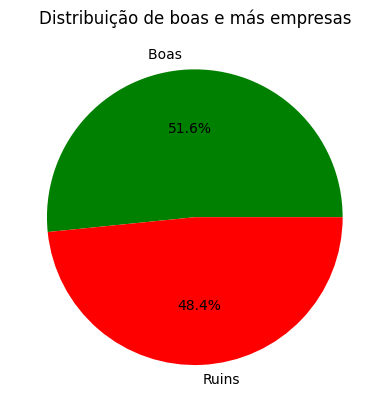

In [ ]:
good_count = len(good_companies)
bad_count = len(bad_companies)

labels = ["Boas ", "Ruins"]
colors = ["green", "red"]

plt.pie([good_count, bad_count], labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Distribuição de boas e más empresas")
plt.show()

In [ ]:
# Função para visualizar a classificação das empresas
def visualizar_empresas(dados):
    plt.figure(figsize=(10,6))
    sns.countplot(x='City', hue='Tipo de Empresa', data=dados, palette='coolwarm')
    plt.title('Empresas Boas vs Ruins por Cidade')
    plt.xlabel('Cidade')
    plt.ylabel('Quantidade de Empresas')
    plt.legend(title='Tipo de Empresa')
    plt.show()

# Função genérica para validar entradas numéricas
def obter_numero_valido(mensagem, tipo="float", intervalo=None):
    while True:
        try:
            valor = float(input(mensagem)) if tipo == "float" else int(input(mensagem))
            if intervalo and not (intervalo[0] <= valor <= intervalo[1]):
                print(f"Erro: O valor deve estar entre {intervalo[0]} e {intervalo[1]}.")
            else:
                return valor
        except ValueError:
            print("Erro: Insira um valor numérico válido.")

In [ ]:
# Função para remover uma empresa
def remover_empresa(dados):
    print("\n=== Remover Empresa ===")
    print(dados[['City', 'Total', 'Rating']].tail())  # Mostra as últimas empresas
    indice_remover = obter_numero_valido("Digite o índice da empresa a ser removida: ", tipo="int", intervalo=(0, len(dados)-1))

    # Remover a empresa com base no índice
    dados = dados.drop(index=indice_remover).reset_index(drop=True)
    print(f"\nEmpresa no índice {indice_remover} removida com sucesso!")

    return dados

In [ ]:
def exibir_menu():
    """Exibe o menu de opções para gerenciamento de empresas."""
    print("\n=== Gerenciar Empresas ===")
    print("1. Adicionar Empresa")
    print("2. Remover Empresa")
    print("3. Ver Tabela de Empresas")
    print("4. Voltar")


def exibir_tabela(dados):
    """Exibe a tabela de empresas corretamente, seja no Jupyter ou no terminal."""
    if "display" in globals():
        display(dados)  # Para Jupyter Notebook
    else:
        print(dados)  # Para execução em terminal


def gerenciar_empresas(dados):
    """Permite adicionar, remover ou visualizar empresas de forma interativa."""
    while True:
        exibir_menu()
        escolha = obter_numero_valido("Escolha uma opção: ", tipo="int", intervalo=(1, 4))

        if escolha == 1:
            dados = adicionar_empresa(dados)
        elif escolha == 2:
            dados = remover_empresa(dados)
        elif escolha == 3:
            print("\nTabela de Empresas:")
            exibir_tabela(dados)  # Chama a função de exibição
        elif escolha == 4:
            print("\nRetornando ao menu principal...")
            break  # Sai do loop

    return dados

In [ ]:
# Função para calcular a média de avaliações
def calcular_media_avaliacao(dados):
    return dados['Rating'].mean()

# Função principal que executa a classificação, visualização e gestão de empresas
def executar_fluxo_empresas(dados):
    # Calcula a média das avaliações atuais
    media_avaliacao = calcular_media_avaliacao(dados)
    print(f"\nA avaliação média atual é: {media_avaliacao:.2f}\n")


    # Bloco de gerenciamento (adição ou remoção) de empresas
    dados = gerenciar_empresas(dados)

    # Recalcular a média de avaliação após modificações nas empresas
    media_avaliacao = calcular_media_avaliacao(dados)
    print(f"\nNova avaliação média: {media_avaliacao:.2f}")

    # Reclassificar as empresas e visualizar novamente
    dados = classificar_empresas(dados, media_avaliacao)
    visualizar_empresas(dados)

    return dados

In [ ]:
# Definir a média de empresa "Ruim" como 6.97
avaliacao_ruim = 6.97

# Função para classificar as empresas como "Boas" ou "Ruins"
def classificar_empresas(dados, avaliacao_ruim):
    # Criar uma nova coluna 'Tipo de Empresa' para classificar
    dados['Tipo de Empresa'] = np.where(dados['Rating'] >= avaliacao_ruim, 'Boa', 'Ruim')
    return dados

# Classificar empresas existentes como "Boas" ou "Ruins"
dados = classificar_empresas(dados, avaliacao_ruim)

# Exibir as primeiras linhas dos dados classificados
print(dados[['City', 'Total', 'Rating', 'Tipo de Empresa']].head())

        City     Total  Rating Tipo de Empresa
0     Yangon  548.9715     9.1             Boa
1  Naypyitaw   80.2200     9.6             Boa
2     Yangon  340.5255     7.4             Boa
3     Yangon  489.0480     8.4             Boa
4     Yangon  634.3785     5.3            Ruim


In [ ]:
# Função para salvar e baixar o arquivo
def salvar_e_baixar(dados, nome_arquivo="empresas_atualizadas.csv"):
    dados.to_csv(nome_arquivo, index=False)
    print(f"\nArquivo salvo como {nome_arquivo}.")

    # Download do arquivo
    files.download(nome_arquivo)  # Baixa o arquivo no Google Colab

# Executar o fluxo principal
dados = gerenciar_empresas(dados)
salvar_e_baixar(dados)